In [8]:
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image
device = 'cuda'
model_path='weights/icon_detect/model.pt'

som_model = get_yolo_model(model_path)

som_model.to(device)
print('model to {}'.format(device))

model to cuda


In [9]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
# import util.utils
# importlib.reload(utils)
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)



In [10]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [11]:
# reload utils
import importlib
import utils
importlib.reload(utils)
# from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

# image_path = 'imgs/google_page.png'
# image_path = 'imgs/windows_home.png'
# image_path = 'imgs/windows_multitab.png'
# image_path = 'imgs/omni3.jpg'
# image_path = 'imgs/ios.png'
image_path = 'imgs/farcry6.jpg'
# image_path = 'imgs/excel2.png'

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=True)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time() 

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
cur_time_caption = time.time() 


image size: (1280, 720)

0: 736x1280 13 icons, 15.1ms
Speed: 3.0ms preprocess, 15.1ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)
len(filtered_boxes): 13 10
time to get parsed content: 0.060761213302612305


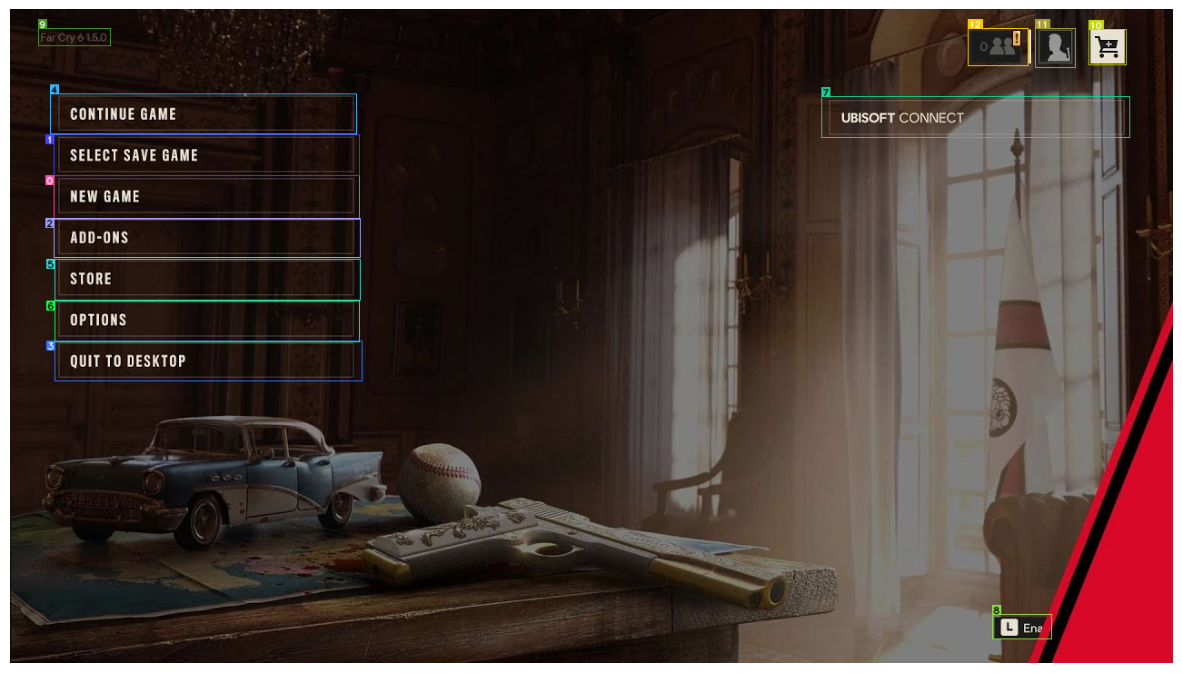

In [12]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))


In [13]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,source,ID
0,icon,"[0.03824407979846001, 0.2554958760738373, 0.30...",True,NEW GAME,box_yolo_content_ocr,0
1,icon,"[0.03819572925567627, 0.19288580119609833, 0.3...",True,SELECT SAVE GAME,box_yolo_content_ocr,1
2,icon,"[0.038204263895750046, 0.3198552429676056, 0.3...",True,ADD-ONS,box_yolo_content_ocr,2
3,icon,"[0.03838346153497696, 0.5075779557228088, 0.30...",True,QUIT TO DESKTOP,box_yolo_content_ocr,3
4,icon,"[0.03474771976470947, 0.12981747090816498, 0.2...",True,CONTINUE GAME,box_yolo_content_ocr,4
5,icon,"[0.038385987281799316, 0.382109671831131, 0.30...",True,STORE,box_yolo_content_ocr,5
6,icon,"[0.03837933391332626, 0.44660380482673645, 0.3...",True,OPTIONS,box_yolo_content_ocr,6
7,icon,"[0.6977294683456421, 0.13340358436107635, 0.96...",True,UBISOFT CONNECT,box_yolo_content_ocr,7
8,icon,"[0.8449503183364868, 0.9253334999084473, 0.895...",True,Ene,box_yolo_content_ocr,8
9,icon,"[0.02441316843032837, 0.030023036524653435, 0....",True,Far Cry61.5.0,box_yolo_content_ocr,9


In [14]:
parsed_content_list

[{'type': 'icon',
  'bbox': [0.03824407979846001,
   0.2554958760738373,
   0.30035796761512756,
   0.3221246004104614],
  'interactivity': True,
  'content': 'NEW GAME ',
  'source': 'box_yolo_content_ocr'},
 {'type': 'icon',
  'bbox': [0.03819572925567627,
   0.19288580119609833,
   0.3002786338329315,
   0.25548961758613586],
  'interactivity': True,
  'content': 'SELECT SAVE GAME ',
  'source': 'box_yolo_content_ocr'},
 {'type': 'icon',
  'bbox': [0.038204263895750046,
   0.3198552429676056,
   0.30125492811203003,
   0.37991172075271606],
  'interactivity': True,
  'content': 'ADD-ONS ',
  'source': 'box_yolo_content_ocr'},
 {'type': 'icon',
  'bbox': [0.03838346153497696,
   0.5075779557228088,
   0.3026406168937683,
   0.5690092444419861],
  'interactivity': True,
  'content': 'QUIT TO DESKTOP ',
  'source': 'box_yolo_content_ocr'},
 {'type': 'icon',
  'bbox': [0.03474771976470947,
   0.12981747090816498,
   0.2980983853340149,
   0.19132061302661896],
  'interactivity': True,
 